In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
import time


In [2]:
# returns HOG features and visualization
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    if(vis==True):
        features,hog_image=hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell),block_norm='L2-Hys',
                              cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=True,
                              visualise=vis,feature_vector=feature_vec)
        return features,hog_image
    else:
        features=hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell),
                              cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=True,
                              visualise=vis,feature_vector=feature_vec)
        return features

In [3]:
#to return binary colored features
def bin_spatial(img,size=(32,32)):
    use=cv2.resize(img,size).ravel()
    return use

In [4]:
def color_hist(img,nbins=32,bins_range=(0,256)):
    channel1_hist=np.histogram(img[:,:,0],bins=nbins, range=bins_range)
    channel2_hist=np.histogram(img[:,:,1],bins=nbins, range=bins_range)
    channel3_hist=np.histogram(img[:,:,2],bins=nbins, range=bins_range)
    
    hist_features=np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)*255
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            #print(hog_channel)
            if(hog_channel == 'ALL'):
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [5]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Read in cars and notcars
non_vehicles_images = glob.glob('C://Users//Shivam.Chawla01//CarND-Vehicle-Detection//test data//non-vehicles//*//*//*.png')
vehicles_images = glob.glob('C://Users//Shivam.Chawla01//CarND-Vehicle-Detection//test data//vehicles//*//*//*.png')

                
                
cars = []

notcars = []
for image in non_vehicles_images:
#     if 'image' in image or 'extra' in image:
    notcars.append(image)
for image in vehicles_images:
#     if 'image' in image or 'extra' in image:
    cars.append(image)

        
# print(len(notcars))
# print(len(cars))
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 500
cars = cars[0:]
notcars = notcars[0:]

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient=11  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
x_start_stop = [600, None]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler

# Apply the scaler to X
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = SVC(kernel='rbf')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

C:\Users\Shivam.Chawla01\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Shivam.Chawla01\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2052
58.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9955


In [8]:
from scipy.ndimage.measurements import label
image = mpimg.imread('test1.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        #bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        if((np.max(nonzerox)-np.min(nonzerox))>=((np.max(nonzeroy)-np.min(nonzeroy)))):
            if (((np.max(nonzerox)-np.min(nonzerox))>30) & ((np.max(nonzeroy)-np.min(nonzeroy))>30)):
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        else:
            diff=((np.max(nonzeroy)-np.min(nonzeroy)))-(np.max(nonzerox)-np.min(nonzerox))
            y=np.max(nonzeroy)-diff
            if (((np.max(nonzerox)-np.min(nonzerox))>30) & ((np.max(nonzeroy)-np.min(nonzeroy))>30)):
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), y))
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
           
    # Return the image
    return img

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

In [9]:

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=16, cell_per_block=2, hog_channel='All',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == ' ':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        
        if(hog_channel=='ALL'):
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

C:\Users\Shivam.Chawla01\AppData\Local\Continuum\anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[((826, 400), (890, 464)), ((858, 400), (922, 464)), ((874, 400), (938, 464)), ((810, 416), (874, 480)), ((826, 416), (890, 480)), ((858, 416), (922, 480)), ((874, 416), (938, 480)), ((890, 416), (954, 480)), ((810, 432), (874, 496)), ((890, 432), (954, 496)), ((818, 400), (914, 496)), ((842, 400), (938, 496)), ((866, 400), (962, 496)), ((1058, 400), (1154, 496)), ((810, 400), (938, 528)), ((1130, 400), (1258, 528)), ((1120, 400), (1280, 560))]


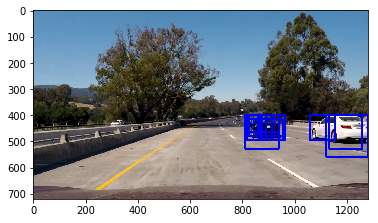

In [32]:
image = mpimg.imread('.//test_images//frame1010.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[650, None], y_start_stop=[400,500], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
windows1 = slide_window(image, x_start_stop=[650, None], y_start_stop=[400,656], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows2 = slide_window(image, x_start_stop=[650, None], y_start_stop=[400,656], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows3 = slide_window(image, x_start_stop=[650, None], y_start_stop=[400,656], 
                    xy_window=(160, 160), xy_overlap=(0.75, 0.75))
windows4 = slide_window(image, x_start_stop=[1000, None], y_start_stop=[400,656], 
                    xy_window=(160, 160), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
hot_windows1 = search_windows(image, windows1, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
hot_windows2 = search_windows(image, windows2, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
hot_windows3 = search_windows(image, windows3, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
hot_windows4 = search_windows(image, windows4, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# hot_windows=np.mean([hot_windows,hot_windows1,hot_windows2],axis=0)
hot_windows_total=hot_windows+hot_windows1+hot_windows2+hot_windows3+hot_windows4
print(hot_windows_total)
window_img = draw_boxes(draw_image, hot_windows_total, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

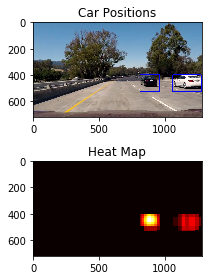

In [33]:
# Add heat to each box in box list

heat1 = add_heat(heat,hot_windows_total)
heat2 = add_heat(heat,hot_windows1)
heat3 = add_heat(heat,hot_windows2)
# print(heat1)
# Apply threshold to help remove false positives

heat1 = apply_threshold(heat1,4)
# heat2 = apply_threshold(heat2,4)
# heat3 = apply_threshold(heat3,4)
# print(heat1)
# Visualize the heatmap when displaying    
heatmap1 = np.clip(heat1, 0, 255)
heatmap2 = np.clip(heat2, 0, 255)
heatmap3 = np.clip(heat3, 0, 255)

heatmap=np.mean([heatmap1,heatmap2,heatmap3],axis=0)

# Find final boxes from heatmap using label function
labels = label(heatmap1)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(211)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(212)
plt.imshow(heatmap1, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [34]:
def Generate_Video(imag):
    image = mpimg.imread('test1.jpg')
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    windows = slide_window(imag, x_start_stop=[650, None], y_start_stop=[400,500], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    windows1 = slide_window(imag, x_start_stop=[650, None], y_start_stop=[400,656], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows2 = slide_window(imag, x_start_stop=[650, None], y_start_stop=[400,656], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    windows3 = slide_window(imag, x_start_stop=[650, None], y_start_stop=[400,656], 
                    xy_window=(160, 160), xy_overlap=(0.75, 0.75))
    windows4 = slide_window(imag, x_start_stop=[1000, None], y_start_stop=[400,656], 
                    xy_window=(160, 160), xy_overlap=(0.75, 0.75))
#     windows5 = slide_window(imag, x_start_stop=[1050, None], y_start_stop=[400,656], 
#                     xy_window=(160, 160), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(imag, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    hot_windows1 = search_windows(imag, windows1, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    hot_windows2 = search_windows(imag, windows2, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    hot_windows3 = search_windows(imag, windows3, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    hot_windows4 = search_windows(imag, windows4, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
#     hot_windows4 = search_windows(imag, windows5, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)
#     hot_windows=np.mean(hot_windows,hot_windows1,hot_windows2)
    
#     print(hot_windows)
    hot_windows_total1=hot_windows+hot_windows1+hot_windows2+hot_windows3+hot_windows4#+hot_windows5
    window_img = draw_boxes(imag, hot_windows_total1, color=(0, 0, 255), thick=6)
    heat1 = add_heat(heat,hot_windows_total1)
    heat2 = add_heat(heat,hot_windows1)
    heat3 = add_heat(heat,hot_windows2)
    
# Apply threshold to help remove false positives
    
    heat1 = apply_threshold(heat1,4)
#     heat2 = apply_threshold(heat2,4)
#     heat3 = apply_threshold(heat3,4)

# Visualize the heatmap when displaying    
    heatmap1 = np.clip(heat1, 0, 255)
    heatmap2 = np.clip(heat2, 0, 255)
    heatmap3 = np.clip(heat3, 0, 255)
    
    heatmap=np.mean([heatmap1,heatmap2,heatmap3],axis=0)

# Find final boxes from heatmap using label function
    labels = label(heatmap1)
    draw_img = draw_labeled_bboxes(np.copy(imag), labels)
    return draw_img


In [35]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(40,45)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Generate_Video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:06:45<00:03,  3.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 1h 6min 47s
